In [5]:
#import libraries 
from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import folium

#### Let's load the neighborhoods data and look at the first few rows
(https://data.nashville.gov/Metro-Government/Neighborhood-Association-Boundaries-GIS-/qytv-2cu8)


In [6]:
neighborhoods = gpd.read_file('./data/Neighborhood Association Boundaries (GIS).geojson')
neighborhoods.head()

,name,geometry
0,Historic Buena Vista,(POLYGON ((-86.79511056795417 36.1757596496334...
1,Charlotte Park,(POLYGON ((-86.87459668651866 36.1575770268129...
2,Hillwood,(POLYGON ((-86.87613708067906 36.1355409894979...
3,West Meade,"(POLYGON ((-86.9038380396094 36.1255414807897,..."
4,White Bridge,(POLYGON ((-86.86321427797685 36.1288622289404...


#### Now let's look at the difference between calling a geometry variable.....


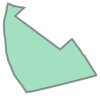

In [7]:
neighborhoods.loc[0, 'geometry']

#### ...and printing it


In [8]:
print(neighborhoods.loc[0, 'geometry'])

MULTIPOLYGON (((-86.79511056795417 36.17575964963348, -86.79403325521203 36.17672381962277, -86.79395847673587 36.17673420120556, -86.79373059621346 36.17641850227536, -86.79345684770965 36.1760073285478, -86.7933653702227 36.17592609720739, -86.79294909679425 36.17527664780614, -86.79276591717007 36.17511962002857, -86.79252941560033 36.17471240878589, -86.79204396927803 36.17393170332863, -86.79167790414918 36.17334940652481, -86.7916936044697 36.17329298843413, -86.79203101691085 36.1731861114189, -86.79474163086816 36.17249213438422, -86.79601903802255 36.17218267273473, -86.79764416397879 36.17179978743778, -86.79830164245051 36.17168336043859, -86.79879977448026 36.17243166386886, -86.79924036890505 36.1729960002125, -86.79949254372757 36.1733962443001, -86.79962585216791 36.17371402180879, -86.79978177579596 36.17412395085653, -86.8000340272343 36.17467828643516, -86.80014485213776 36.17518521060327, -86.80021778306909 36.17542866685226, -86.80031177458922 36.17668510380093, -86

#### Plotting a GeoDataFrame is as easy as calling the GeoPandas .plot() function


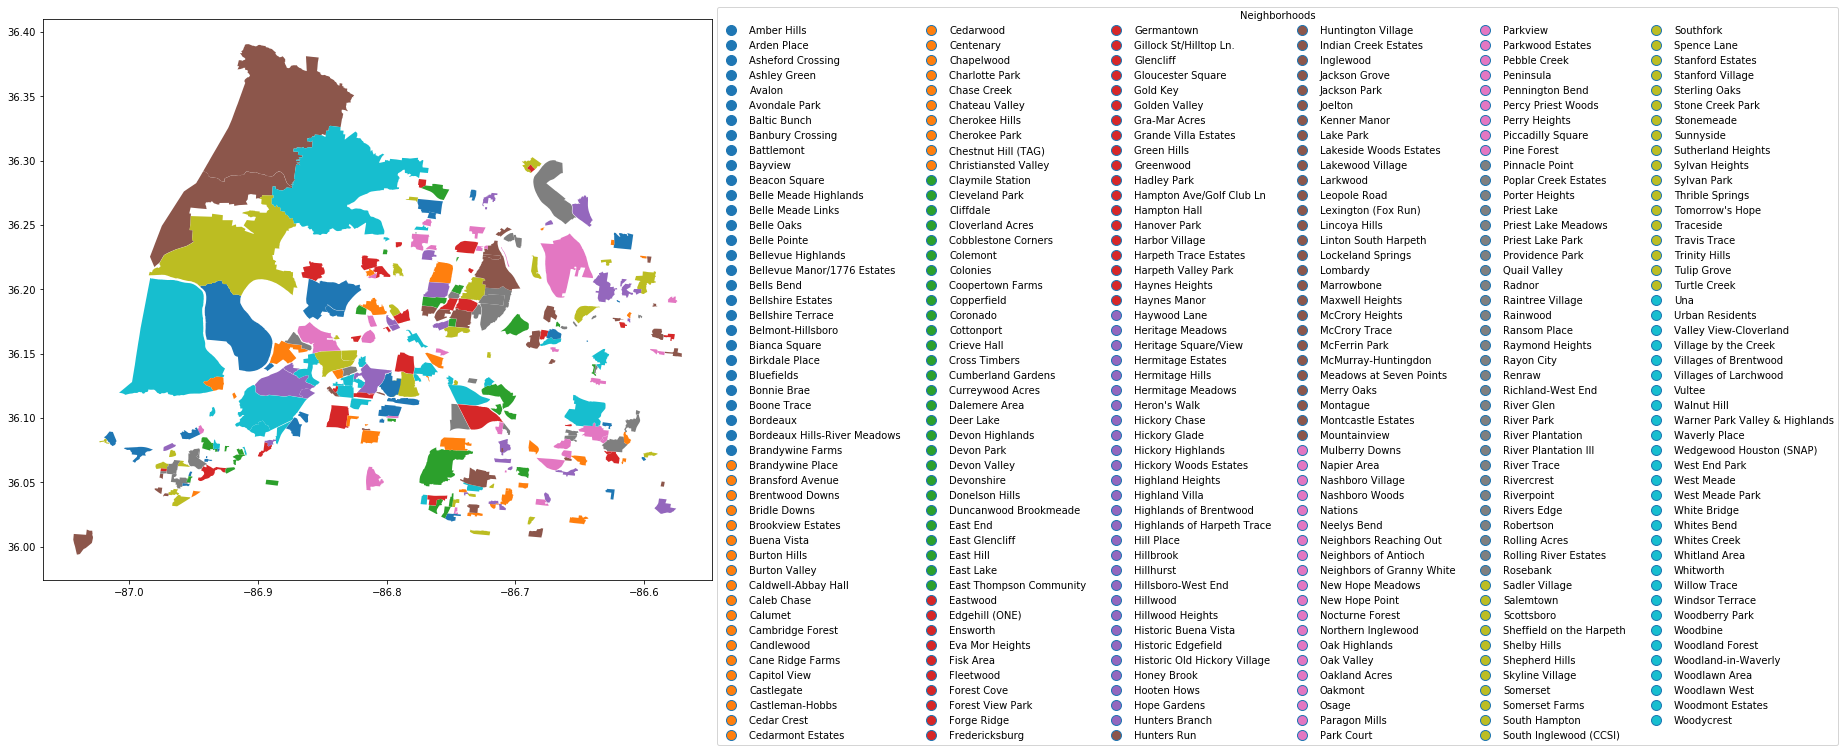

In [9]:
#geopandas handles legend styling if you pass a dict of keywords
leg_kwds = {'title': 'Neighborhoods', 'loc': 'upper left', 'bbox_to_anchor': (1, 1.03), 'ncol': 6}
neighborhoods.plot(column = 'name', figsize=(12, 12), legend = True, legend_kwds = leg_kwds)
plt.show()

#### A little overwhelming...how can we find the neighborhood with the most art? Let's load the public art data and look at the first few rows
https://data.nashville.gov/Art/Art-in-Public-Places/dqkw-tj5j/data

In [27]:
art = pd.read_csv('/Users/rabram/Desktop/NSS/Nashville-Public-Art/data/public_art.csv')
art.head()

,Title,Last Name,First Name,Location,Medium,Type,Description,Latitude,Longitude,Mapped Location
0,[Cross Country Runners],Frost,Miley,"4001 Harding Rd., Nashville TN",Bronze,Sculpture,NaN,36.12856,-86.83660,"(36.12856, -86.8366)"
1,[Fourth and Commerce Sculpture],Walker,Lin,"333 Commerce Street, Nashville TN",NaN,Sculpture,NaN,36.16234,-86.77774,"(36.16234, -86.77774)"
2,12th & Porter Mural,Kennedy,Kim,114 12th Avenue N,Porter all-weather outdoor paint,Mural,Kim Kennedy is a musician and visual artist wh...,36.15790,-86.78817,"(36.1579, -86.78817)"
3,A Splash of Color,Stevenson and Stanley and ROFF (Harroff),Doug and Ronnica and Lynn,616 17th Ave. N.,"Steel, brick, wood, and fabric on frostproof c...",Mural,Painted wooden hoop dancer on a twenty foot po...,36.16202,-86.79975,"(36.16202, -86.79975)"
4,A Story of Nashville,Ridley,Greg,"615 Church Street, Nashville TN",Hammered copper repousse,Frieze,"Inside the Grand Reading Room, this is a serie...",36.16215,-86.78205,"(36.16215, -86.78205)"


#### We'll clean up the column names so they don't have spaces, and then use a lambda expression with shapely Point to create a geometry field in the art DataFrame

In [28]:
art.columns = ['title', 'last_name', 'first_name', 'address', 'medium', 'type', 'desc', 'lat', 'lng', 'loc']
art['geometry'] = art.apply(lambda x: Point((float(x.lng), float(x.lat))), axis=1)

#### Now that art has a geometry field, we can convert it from a DataFrame to a GeoDataFrame - we want the CRS to match the CRS in the neighborhoods GeoDataFrame so we set it to that

In [31]:
art_geo = gpd.GeoDataFrame(art, crs = neighborhoods.crs, geometry = art['geometry'])

#### Now we're ready to combine the neighborhoods and the art with a spatial join


In [32]:
neighborhood_art = gpd.sjoin(art_geo, neighborhoods, op = 'within')

In [53]:
neighborhood_art.head()

,title,last_name,first_name,address,medium,type,desc,lat,lng,loc,geometry,index_right,name
1,[Fourth and Commerce Sculpture],Walker,Lin,"333 Commerce Street, Nashville TN",NaN,Sculpture,NaN,36.16234,-86.77774,"(36.16234, -86.77774)",POINT (-86.77774000000001 36.16234),41,Urban Residents
4,A Story of Nashville,Ridley,Greg,"615 Church Street, Nashville TN",Hammered copper repousse,Frieze,"Inside the Grand Reading Room, this is a serie...",36.16215,-86.78205,"(36.16215, -86.78205)",POINT (-86.78205 36.16215),41,Urban Residents
21,Chet Atkins,Faxon,Russell,"Corner of Fifth Avenue North and Union Street,...",Bronze stool and guitar on a granite plynth,Sculpture,A sculpture of a young Chet Atkins seated on a...,36.16466,-86.78102,"(36.16466, -86.78102)",POINT (-86.78102 36.16466),41,Urban Residents
22,Children's Chairs For The Seasons,McGraw,Deloss,"615 Church Street, Nashville TN",Mixed Media - wood and paint,Furniture,chairs depicting the four seasons,36.16215,-86.78205,"(36.16215, -86.78205)",POINT (-86.78205 36.16215),41,Urban Residents
34,Foliated Scroll,Bloomer,Kent,"615 Church Street, Nashville TN",Aluminum,Frieze,a contemporary adaptation of a classical folia...,36.16215,-86.78205,"(36.16215, -86.78205)",POINT (-86.78205 36.16215),41,Urban Residents


#### Now that the data is joined spatially we can aggregate the art by neighborhood and see how many artworks are within each polygon

In [14]:
neighborhood_art[['name', 'title']].groupby('name').agg('count').sort_values(by ='title', ascending = False)

,title
name,
Urban Residents,22
Lockeland Springs,3
Edgehill (ONE),2
Germantown,2
Hillsboro-West End,2
Inglewood,2
Sunnyside,2
Chestnut Hill (TAG),1
Historic Edgefield,1


#### Subset the neighborhood_art to get only the art that is in the downtown 'Urban Residents' neighborhood

In [33]:
urban_art = neighborhood_art.loc[neighborhood_art.name == 'Urban Residents']
urban_art.head()

,title,last_name,first_name,address,medium,type,desc,lat,lng,loc,geometry,index_right,name
1,[Fourth and Commerce Sculpture],Walker,Lin,"333 Commerce Street, Nashville TN",NaN,Sculpture,NaN,36.16234,-86.77774,"(36.16234, -86.77774)",POINT (-86.77774000000001 36.16234),41,Urban Residents
4,A Story of Nashville,Ridley,Greg,"615 Church Street, Nashville TN",Hammered copper repousse,Frieze,"Inside the Grand Reading Room, this is a serie...",36.16215,-86.78205,"(36.16215, -86.78205)",POINT (-86.78205 36.16215),41,Urban Residents
21,Chet Atkins,Faxon,Russell,"Corner of Fifth Avenue North and Union Street,...",Bronze stool and guitar on a granite plynth,Sculpture,A sculpture of a young Chet Atkins seated on a...,36.16466,-86.78102,"(36.16466, -86.78102)",POINT (-86.78102 36.16466),41,Urban Residents
22,Children's Chairs For The Seasons,McGraw,Deloss,"615 Church Street, Nashville TN",Mixed Media - wood and paint,Furniture,chairs depicting the four seasons,36.16215,-86.78205,"(36.16215, -86.78205)",POINT (-86.78205 36.16215),41,Urban Residents
34,Foliated Scroll,Bloomer,Kent,"615 Church Street, Nashville TN",Aluminum,Frieze,a contemporary adaptation of a classical folia...,36.16215,-86.78205,"(36.16215, -86.78205)",POINT (-86.78205 36.16215),41,Urban Residents


#### Get just the 'Urban Residents' polygon from the neighborhoods data and take a look at it

In [16]:
urban_polygon = neighborhoods.loc[neighborhoods.name == 'Urban Residents']
urban_polygon.head() 

,name,geometry
41,Urban Residents,(POLYGON ((-86.78122053774267 36.1645653773768...


#### Plot the Urban Residents Neighborhood and add our public art, coloring the points by the type of art.

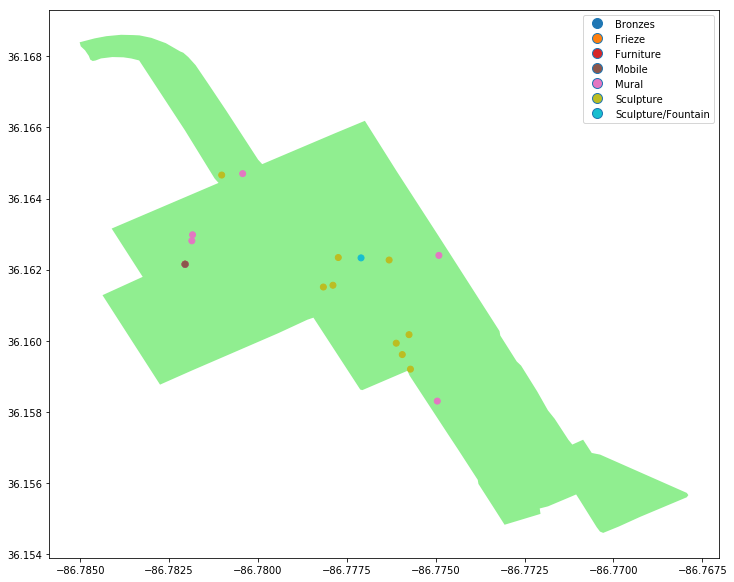

In [35]:
ax = urban_polygon.plot(figsize = (12, 12), color = 'lightgreen')
urban_art.plot( ax = ax, column = 'type', legend = True);
plt.show();

#### We're getting there! It would be helpful to have streets, though wouldn't it? We can add a street map with the folium package.

#### Our folium map wants a center point for the street map. We'll make use of a GeoSeries attribute (.centroid) which gives us the center of a polygon.

In [36]:
#find the center of our urban_polygon and look at it
urban_polygon.geometry.centroid

41    POINT (-86.77756457127047 36.16127820928791)
dtype: object

#### The centroid is actually a pandas series; get the first element

In [37]:
# find the center of the urban polygon with the centroid property
center = urban_polygon.geometry.centroid

# get and store the first occurence which will be a Point geometry
center_point = center.iloc[0]

# print the types for center and center_point
print('center is :', type(center))
print('center_point is :', type(center_point))

center is : <class 'geopandas.geoseries.GeoSeries'>
center_point is : <class 'shapely.geometry.point.Point'>


#### Folium wants a location point as an array with *latitude* first, but shapely Points have *longitude* first

In [23]:
# center point has longitude first
print(center_point)

# reverse the order when constructing the array for folium location
urban_center = [center_point.y, center_point.x]

# check the order of urban_center, the location we'll set for our folium map
print(urban_center)

POINT (-86.77756457127047 36.16127820928791)
[36.161278209287914, -86.77756457127047]


#### Use `urban_center` as the `location` of the folium map. A zoom level of 15 should get us nice and close.

In [46]:
#create our map of Nashville and show it
map_downtown = folium.Map(location =  urban_center, zoom_start = 15)
map_downtown

#### Next, let's add our Urban Residents neighborhood polygon and art markers.

#### `itterows()` is a generator that iterates through the rows of a DataFrame and returns a tuple with the row id and row values. Below, we are printing the row values for each row as we iterate through the GeoDataFrame of urban art. This idea will be helpful for creating our markers!

In [25]:
for row in urban_art.iterrows():
    row_values = row[1]
    print(row_values)

title              [Fourth and Commerce Sculpture]
last_name                                   Walker
first_name                                     Lin
address          333 Commerce Street, Nashville TN
medium                                         NaN
type                                     Sculpture
desc                                           NaN
lat                                        36.1623
lng                                       -86.7777
loc                          (36.16234, -86.77774)
geometry       POINT (-86.77774000000001 36.16234)
index_right                                     41
name                               Urban Residents
Name: 1, dtype: object
title                                       A Story of Nashville
last_name                                                 Ridley
first_name                                                  Greg
address                          615 Church Street, Nashville TN
medium                                  Hammered coppe

#### The map of Nashville (`map_downtown`) has already been created.
* add the downtown neighborhood outline (urban_polygon)
* iterate through the urban art to
    * create location from each lat and lng
    * create a popup from title and type
    * build a marker from each location and popup
    * add the marker to  `map_downtown`
* display `map_downtown`

In [52]:
#draw our neighborhood: Urban Residents
folium.GeoJson(urban_polygon).add_to(map_downtown)

#iterate through our urban art to create locations and markers for each piece
#here lat is listed first!!
#also the apostrophe in the 4th row causes problems!

for row in urban_art.iterrows():
    row_values = row[1] 
    location = [row_values['lat'], row_values['lng']]
    popup = (str(row_values['title']) + ': ' + 
             str(row_values['type']) + '<br/>' +
             str(row_values['desc'])).replace("'", "`")
    marker = folium.Marker(location = location, popup = popup)
    
    marker.add_to(map_downtown)

#display our map
map_downtown